# Quantum Approximate Optimization Algorithm for Integer Variables

## Introduction

In prior tutorials, we have explored how the Quantum Approximate Optimization Algorithm (QAOA) excels in solving Quadratic Unconstrained Binary Optimization (QUBO) problems. As the terminology suggests, QUBO tasks require binary decision-making, typically represented as "1" or "0" for each qubit. Yet, many practical scenarios involve not only binary decisions but also the degrees to which these decisions can be implemented. This is where integer-variable problems come into play.

## What are integer-variable problems?

In an integer-variable problem, we are going to minimize a function according to a set of constraints $R=\{R_i\}$ as below:

$$
X^TQX, \quad 0<X_i<R_i
$$

Here, $X=(X_1,\ldots, X_d)$ is a length $d$ vector with each $X_i\in\mathbb{Z}$ an integer. $Q\in\mathbb{Z}^{d\times d}$ is a symmetric matrix characterizing the optimization problem (called a Q matrix). The goal is to find the optimal values of $X$ that minimize the function while adhering to the specified constraints.

## Quasi-binary Encoding Scheme


While traditional QAOA yields a binary state output, an encoding strategy assigns integers to a binary state. The quasi-binary encoding method introduced by [Chen et al. (2023)](https://arxiv.org/abs/2304.06915) is used here.

For the $i$-th integer variable $X_i$, $n_i$ qubits are needed for QAOA and the upper limits are represented as the sum of several $2^{l_{ij}}$:

$$
n_i = \lfloor\log(R_i+1)\rfloor\\
l_{ij} = \text{bin}_j (R_i-2^{n_i}+1) + 1
$$

where $\lfloor m \rfloor$ denotes the floor of $m$, which rounds down to the nearest integer less than $m$. $\text{bin}_j (R_i-2^{n_i}+1)$ gives the $j$-th bit of $\text{bin} (R_i-2^{n_i}+1)$. Let's take an example and explain the expression above: consider the encoding of integer $8$. a single qubit representing $2^3$ would limit the binary state to values either 0 or 8. However, the quasi-binary encoding uses two qubits for $2^0$, one for $2^1$, and one for $2^2$, cumulatively reaching 8 ($2 \times 2^0 + 1 \times 2^1 + 1 \times 2^2$). This approach allows the binary state to represent any integer within the 0 to 8 range. In this example, four binary numbers collectively form a group representing a single integer.

Let's denote the encoded binary state using a lowercase letter $x$. The $i$-th integer variable $X_i$ is then represented as:

$$
X_i = \sum_j^{n_i} x_{ij}2^{l_{ij}}
$$

where $x_{ij}$ is the $j$-th binary number in the $i$-th group. For $d$ integer values, the vector $x$ should have $d$ groups of binary numbers. We can simplify the encoding procedure by using a transformation matrix $M$ containing all $2^{ij}$ factors. If the total number of elements in $x$ is $k$, the transformation should have $d$ rows and $k$ columns and it looks like:
$$
\begin{bmatrix}
m_1& \\
& m_2& \\
& & \ddots& \\
& & & & m_j\\
\end{bmatrix}
$$

where $m_i$ is the non-zero parts corresponding to the $i$-th integer value and also $i$-th group of binary numbers. Each of them has elements as below:

$$
m_i = \begin{bmatrix}
2^{l_{i,1}}, & 2^{l_{i,2}},&\cdots, & 2^{l_{i,n_{i}}}
\end{bmatrix}
$$

Let's also denote the transformed $Q$ matrix as $q$. The complete encoding scheme is described as:

$$
Mx = X \\
q = M^TQM
$$

## Mathematical Explanation

The objective is to maintain the original value of the target function even after applying the transformation. This condition is expressed mathematically as:

$$
x^Tqx = X^TQX
$$

To facilitate this, we introduce an auxiliary matrix that functions as an "inverse" to the transformation matrix $M$. The transformation matrix is not a square matrix and it technically does not have an inverse. However, we can always find a matrix $N$, which matches $M$ in dimensions (so $N$ has $k$ rows and $d$ columns), such that $MN = I$, where $I$ is a $d \times d$ identity matrix corresponding in size to the Q matrix. This identity can be inserted into the equation while preserving the equality.

$$
x^Tqx = X^T(MN)^TQXMNX = (X^TN^T)(M^TQM)(NX)
$$

By comparing both sides of the equation, we derive:

$$
x = NX \\
q = M^TQM
$$

Multiplying the first equation on the left by $M$ results in:

$$
Mx = X
$$

This step completes the derivation of the transformation relationship, effectively linking the original and transformed quantum states and Q matrices.

## Soft constraint

In standard QAOA, "budget"-like constraints limit the results. This concept is referred to as the soft constraint model. A similar constraint can also be applied in integer-variable QAOA. For instance, if we need the sum of all variables not to exceed a certain value $D$, we can modify the QUBO problem to minimize the following cost function:

$$
x^Tqx + \lambda(n^Tx-D)^2
$$

Here, $n$ is a vector of binary encoding values, essentially a flattened version of the transformation matrix. It can be computed as $n$=`np.sum(M, axis=0)`. The quadratic penalty term, $\lambda(n^Tx-D)^2$, is then expanded and reformulated as:

$$
\lambda(n^Tx-D)^2 = \lambda x^T(L - 2\eta D)x + \lambda D^2
$$

where $\eta$ is a square matrix with the elements of $n$ along its diagonal (computed as  $\eta=\text{np.diag}(n)$), and $L$ is the outer product of two $n$ vectors ($L=n\otimes n$).  To incorporate the soft constraint into the optimization, the Q-matrix needs a transformation as below:

$$
q \to q + \lambda(L - 2\eta D)
$$

An illustrative example of this approach is presented in the final section of this tutorial, demonstrating the practical application of soft constraints in integer-variable QAOA.

## Integer QAOA: An Example

Consider the vector of integer variables $X=[X_1, X_2, X_3]$ with constraints $R=[6, 2, 7]$, and Q matrix:

$$
Q = \left[\begin{array}{rrr}
    -5& -1& 2\\ -1& 6& 0\\ 2& 0& -2\\
\end{array}\right]
$$

To proceed with the encoding strategy outlined previously, we transform the upper limits as follows:

$$
\begin{aligned}
6& \to 2^0+2^0+2^1+2^1 \\
2& \to 2^0+2^0 \\
7& \to 2^0+2^1+2^2
\end{aligned}
$$

This transformation splits each integer variable into binary components based on their upper limits, allowing for a more flexible representation of the variables within the QAOA framework. The transformation matrix of this example should be:

$$
M = \begin{bmatrix}

\end{bmatrix}
$$

## Set Up


In [1]:
from itertools import product

import numpy as np
import tensorcircuit as tc
import matplotlib.pyplot as plt

from tensorcircuit.applications.optimization import QUBO_QAOA
from tensorcircuit.templates.conversions import QUBO_to_Ising
from tensorcircuit.templates.ansatz import QAOA_ansatz_for_Ising

backend = tc.set_backend("tensorflow")

from supply import integer_QAOA_transformation, print_result_cost, print_Q_cost, print_result_prob

In [3]:
Q = np.array([[-5, -1, 2], [-1, 6, 0], [2, 0, -2]])
integers = [6, 2, 7]

The brute-force method is used to find the integer state with the lowest cost.

In [4]:
all_states = []  # all feasible states
costs = []  # the correspoding costs
all_states = [
    list(x)
    for x in product(
        range(integers[0] + 1), range(integers[1] + 1), range(integers[2] + 1)
    )
]
for state in all_states:
    costs.append(np.dot(state, np.dot(Q, state)))
print("state:", all_states[np.argmin(costs)], "\ncost:", np.min(costs))

state: [6, 1, 0] 
cost: -186


# Build the transformed Q matrix

As we mentioned before, a transformation matrix is needed in solving linear integer QAOA. The transformation matrix corresponding to our example, as well as the transformed Q matrix, are automatically given by calling the function `integer_QAOA_transformation`. The matrix is shown below.

In [9]:
q, matrix = integer_QAOA_transformation(Q, integers) # transformation matrix
matrix

array([[1, 1, 2, 2, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 2, 4]])

The brute-force method is first used to find the correct answers. whose costs are the lowest.

The lowest cost of the transformed Q matrix can be found by going through all possible binary states.

In [5]:
print_Q_cost(q, wrap=True)


-------------------------------------
    selection	  |	  cost
-------------------------------------
 111101000	  |	-186.0000
 111110000	  |	-186.0000
 111100000	  |	-180.0000
 111111000	  |	-180.0000
 111101100	  |	-164.0000
 111110100	  |	-164.0000
 111100100	  |	-158.0000
 111111100	  |	-158.0000
-------------------------------------


# QAOA

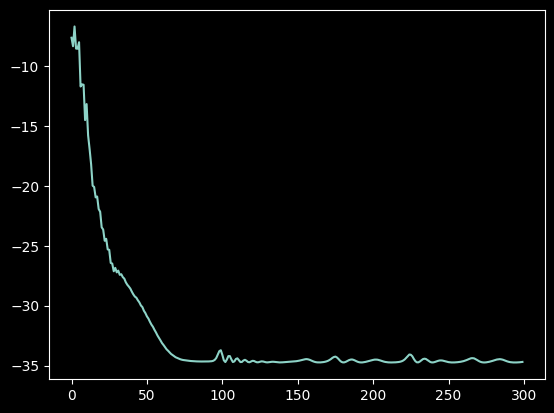

In [6]:
n_layers = 10
n_iter = 300
loss_list = []
def callback(loss, _):
    loss_list.append(loss)
params = QUBO_QAOA(q, n_layers, n_iter, callback=callback)
plt.plot(loss_list)

In [7]:
pauli_terms, weights, _ = QUBO_to_Ising(q)
c_final = QAOA_ansatz_for_Ising(
    params, n_layers, pauli_terms, weights
)
print_result_prob(c_final, wrap=True)


-------------------------------------
    selection	  |	probability
-------------------------------------
 111101010	  |	  0.0441
 111110010	  |	  0.0441
 111110111	  |	  0.0389
 111101111	  |	  0.0389
               ... ...
 011011001	  |	  0.0000
 101111101	  |	  0.0000
 100011100	  |	  0.0000
-------------------------------------


In [8]:
dec = []
for i in '111110000':
    dec.append(int(i))
integer_variable = np.dot(matrix, np.transpose([dec])).tolist()
print(f"the integer variables with highest probability is {integer_variable}")

the decimal state with highest probability is [[6], [1], [0]]


# With constraint

Incorporating a "budget" constraint into integer-variable QAOA allows for controlling the sum of the integer state, in this case, setting it to 6. To apply this constraint, we utilize specific matrices as follows:

The transformation matrix $M$, the vector $n$ representing the flattened version of $M$, the matrix $L$ as the outer product of two $n$ vectors, and $\eta$, a matrix with the elements of $n$ on its diagonal, are defined as:

$$
M = \begin{bmatrix}
       1& 1& 2& 2& 0& 0& 0& 0& 0\\
       0& 0& 0& 0& 1& 1& 0& 0& 0\\
       0& 0& 0& 0& 0& 0& 1& 2& 4
\end{bmatrix}\\
\ \\
n = \begin{pmatrix}
       1& 1& 2& 2& 1& 1& 1& 2& 4
\end{pmatrix}^T\\
\ \\
L = \begin{bmatrix}
        1&  1&  2&  2&  1&  1&  1&  2&  4\\
        1&  1&  2&  2&  1&  1&  1&  2&  4\\
        2&  2&  4&  4&  2&  2&  2&  4&  8\\
        2&  2&  4&  4&  2&  2&  2&  4&  8\\
        1&  1&  2&  2&  1&  1&  1&  2&  4\\
        1&  1&  2&  2&  1&  1&  1&  2&  4\\
        1&  1&  2&  2&  1&  1&  1&  2&  4\\
        2&  2&  4&  4&  2&  2&  2&  4&  8\\
        4&  4&  8&  8&  4&  4&  4&  8& 16
\end{bmatrix}\\
\ \\
\eta = \begin{bmatrix}
       1& 0& 0& 0& 0& 0& 0& 0& 0\\
       0& 1& 0& 0& 0& 0& 0& 0& 0\\
       0& 0& 2& 0& 0& 0& 0& 0& 0\\
       0& 0& 0& 2& 0& 0& 0& 0& 0\\
       0& 0& 0& 0& 1& 0& 0& 0& 0\\
       0& 0& 0& 0& 0& 1& 0& 0& 0\\
       0& 0& 0& 0& 0& 0& 1& 0& 0\\
       0& 0& 0& 0& 0& 0& 0& 2& 0\\
       0& 0& 0& 0& 0& 0& 0& 0& 4\\
\end{bmatrix}
$$

The function integer_QAOA_transformation can automatically implement the budget constraint. By passing the budget argument, the matrices above are internally generated, streamlining the process. The syntax for this function and an alternative brute-force method to identify the optimal solution under the budget constraint are provided in the following part.

In [9]:
q, matrix = integer_QAOA_transformation(Q, integers, budget=6, penalty=10) # transformation matrix
print_Q_cost(q, wrap=True) # print the costs of all binary states


-------------------------------------
    selection	  |	  cost
-------------------------------------
 111100000	  |	-540.0000
 111101000	  |	-536.0000
 111110000	  |	-536.0000
 111100100	  |	-508.0000
 111111000	  |	-500.0000
 011101000	  |	-489.0000
 011110000	  |	-489.0000
 101101000	  |	-489.0000
-------------------------------------


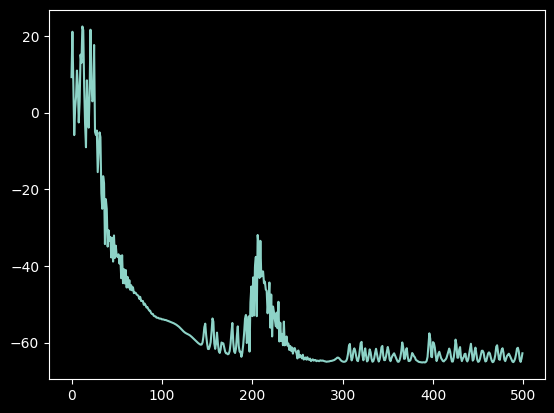

In [10]:
n_layers = 12
n_iter = 500
loss_list = []
params = QUBO_QAOA(q, n_layers, n_iter, callback=callback)
plt.plot(loss_list)

In [11]:
pauli_terms, weights, _ = QUBO_to_Ising(q)
c_final = QAOA_ansatz_for_Ising(
    params, n_layers, pauli_terms, weights
)
print_result_prob(c_final, wrap=True)


-------------------------------------
    selection	  |	probability
-------------------------------------
 111100000	  |	  0.0358
 111100100	  |	  0.0229
 111101000	  |	  0.0167
 111110000	  |	  0.0167
               ... ...
 110111111	  |	  0.0000
 100001000	  |	  0.0000
 010010000	  |	  0.0000
-------------------------------------


In [12]:
dec = []
for i in '111100000':
    dec.append(int(i))
integer_variable = np.dot(matrix, np.transpose([dec])).tolist()
print(f"the integer variables with highest probability are {integer_variable}")

the decimal state with highest probability is [[6], [0], [0]]
